In [1]:
import pandas as pd
import numpy as np

# Metadata from files
"""
Airport_Codes:
    TYPE = str
    NAME = str
    ELEVATION_FT = float, nullable <- not relevant to use case
    CONTINENT = str, nullable
    ISO_COUNTRY = str
    MUNICIPALITY = str
    IATA_CODE = str, nullable
    COORDINATES = str

Flights:
    FL_DATE = date
    OP_CARRIER = str
    TAIL_NUM = str, nullable
    OP_CARRIER_FL_NUM = str
    ORIGIN_AIRPORT_ID = str
    ORIGIN = str
    ORIGIN_CITY_NAME = str
    DEST_AIRPORT_ID = str
    DESTINATION = str, nullable
    DEST_CITY_NAME = str, nullable
    DEP_DELAY = float
    ARR_DELAY = float
    CANCELLED = bool
    AIR_TIME = float
    DISTANCE = float
    OCCUPANCY_RATE = float, nullable

Tickets:
    ITIN_ID = str
    YEAR = int
    QUARTER = int
    ORIGIN = str
    ORIGIN_COUNTRY = str
    ORIGIN_STATE_ABR = str
    ORIGIN_STATE_NM = str
    ROUNDTRIP = int
    REPORTING_CARRIER = str
    PASSENGERS = int
    ITIN_FARE = float
    DESTINATION = str
"""

# create source data object
# load data from CSV
# ***source files were loaded to kernel for this use case, please modify path for local runs
class src_airport:
    codes = pd.read_csv('Airport_Codes.csv', engine='python')
    flights = pd.read_csv('Flights.csv', engine='python')
    tickets = pd.read_csv('Tickets.csv', engine='python')

In [2]:
'''
Create 2 dataframes of each source file, good and bad data.
Continue processing good data.
Send bad data to upstream for revision <- nice to have 
'''
# post import processing to fix formatting and tag invalid data
def tag_invalid_date_values(df, columns_to_tag):
    for col in columns_to_tag:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        #df.replace(pd.NaT, np.nan, inplace=True)
    return df


def tag_invalid_numeric_values(df, columns_to_tag):
    for col in columns_to_tag:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    return df


def tag_invalid_negative_values(df, columns_to_tag):
    for col in columns_to_tag:
        df[col] =  df[col].mask((df[col] < 0))
    return df


def tag_invalid_boolnum_values(df, columns_to_tag):
    for col in columns_to_tag:
        df[col] =  df[col].mask((df[col] < 0) & (df[col] > 1))
    return df


def filter_all_dataframe(df1,df2):
    # merge both dataframes
    merged_df = df1.merge(df2, how='left', indicator=True)
    # filter left only
    filtered_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
    return filtered_df

# flights data

src_airport.flights = tag_invalid_date_values(src_airport.flights,['FL_DATE'])
src_airport.flights = tag_invalid_numeric_values(src_airport.flights,['DEP_DELAY','ARR_DELAY','CANCELLED','AIR_TIME','DISTANCE','OCCUPANCY_RATE'])
src_airport.flights = tag_invalid_negative_values(src_airport.flights,['AIR_TIME','DISTANCE','OCCUPANCY_RATE'])
src_airport.flights = tag_invalid_boolnum_values(src_airport.flights,['CANCELLED'])
src_airport.flights.loc[src_airport.flights['CANCELLED'] == 1] = src_airport.flights.loc[src_airport.flights['CANCELLED'] == 1].fillna({'DEP_DELAY': 0, 'ARR_DELAY': 0, 'AIR_TIME': 0, 'DISTANCE': 0, 'OCCUPANCY_RATE': 0}) # fields are set to null on cancelled flights

# tickets data
src_airport.tickets = tag_invalid_numeric_values(src_airport.tickets,['ROUNDTRIP','PASSENGERS','ITIN_FARE'])
src_airport.tickets = tag_invalid_boolnum_values(src_airport.tickets,['ROUNDTRIP'])
src_airport.tickets = tag_invalid_negative_values(src_airport.tickets,['PASSENGERS','ITIN_FARE'])


# airport codes
codes_clean_df = src_airport.codes.dropna(subset=src_airport.codes.select_dtypes(include=np.number).columns) # step not required, included for scalability
codes_dirty_df = filter_all_dataframe(src_airport.codes,codes_clean_df)  # step not required, included for scalability
# flights
flights_clean_df = src_airport.flights.dropna(subset=src_airport.flights.select_dtypes(include=np.number).columns)
flights_dirty_df = filter_all_dataframe(src_airport.flights,flights_clean_df)
# tickets
tickets_clean_df = src_airport.tickets.dropna(subset=src_airport.tickets.select_dtypes(include=np.number).columns)
tickets_dirty_df = filter_all_dataframe(src_airport.tickets,tickets_clean_df)

In [3]:
# assertion check
assert len(codes_clean_df) + len(codes_dirty_df) == len(src_airport.codes)
assert len(flights_clean_df) + len(flights_dirty_df) == len(src_airport.flights)
assert len(tickets_clean_df) + len(tickets_dirty_df) == len(src_airport.tickets)

In [4]:
# build route data
route_df = tickets_clean_df.groupby(['ORIGIN','DESTINATION']).agg(ROUNDTRIP=('ROUNDTRIP','sum'), AVG_FARE = ('ITIN_FARE','mean')).reset_index()

In [5]:
# get flight cancellation stats per route
cancelled_flight_df = flights_clean_df.groupby(['ORIGIN','DESTINATION'])['CANCELLED'].agg('sum').reset_index()

In [6]:
# merge route data with cancellation stats 
busiest_df = route_df[['ORIGIN','DESTINATION','ROUNDTRIP','AVG_FARE']].merge(cancelled_flight_df, how='left', on = ['ORIGIN','DESTINATION'])
busiest_df.fillna({'CANCELLED':0},inplace=True)
busiest_df['DELTA'] = busiest_df['ROUNDTRIP'] - busiest_df['CANCELLED']
busiest_df['ROUTE'] = busiest_df['ORIGIN'].str.cat(busiest_df['DESTINATION'], sep='-to-')
busiest_vis = busiest_df.nlargest(10,['ROUNDTRIP'], keep='all').copy()

In [7]:
# cost calculator functions
def airport_cost(ap_size):
    match ap_size:
        case 'large_airport':
            return 10000
        case 'medium_airport':
            return 5000
        case _:
            return 0

def fixed_overhead_cost(distance):
    operational = distance * 8
    insurance = distance * 1.18
    total = operational + insurance
    return total

def delay_cost(delay):
    if delay > 15:
        return np.ceil(delay - 15) * 75
    else:
        return 0
    

In [8]:
# flight costs
flight_path_df = flights_clean_df.loc[flights_clean_df['CANCELLED'] == 0].groupby(['ORIGIN','DESTINATION','DISTANCE']).agg(AVG_DEP_DELAY = ('DEP_DELAY','mean'), AVG_ARR_DELAY =  ('ARR_DELAY','mean'), AVG_OCCUPANCY_RATE = ('OCCUPANCY_RATE','mean')).reset_index()
flight_path_df = flight_path_df.merge(codes_clean_df[['IATA_CODE','TYPE']], how = 'left', left_on = 'ORIGIN', right_on = 'IATA_CODE')
flight_path_df = flight_path_df.merge(codes_clean_df[['IATA_CODE','TYPE']], how = 'left', left_on = 'DESTINATION', right_on = 'IATA_CODE', suffixes=('_origin', '_dest'))
flight_path_df['AIRPORT_FEE'] = flight_path_df.apply(lambda x: airport_cost(x['TYPE_origin']) + airport_cost(x['TYPE_dest']), axis=1)
flight_path_df['AVG_DELAY_FEE'] = flight_path_df.apply(lambda x: delay_cost(x['AVG_DEP_DELAY']) + delay_cost(x['AVG_ARR_DELAY']), axis=1)
flight_path_df['OVERHEAD_COST'] = flight_path_df['DISTANCE'].apply(lambda x: fixed_overhead_cost(x))
flight_path_df['OPERATION_COST'] = flight_path_df['OVERHEAD_COST'] + flight_path_df['AVG_DELAY_FEE']

In [9]:
# proposal data
proposal_df = busiest_df.merge(flight_path_df[['ORIGIN','DESTINATION','AIRPORT_FEE','OVERHEAD_COST','OPERATION_COST','AVG_OCCUPANCY_RATE']], how = 'left', on = ['ORIGIN','DESTINATION'])
proposal_df['REVENUE'] = ((proposal_df['AVG_OCCUPANCY_RATE'] * 200) * proposal_df['AVG_FARE']) - proposal_df['AIRPORT_FEE'] - proposal_df['AIRPORT_FEE'] - proposal_df['OPERATION_COST']
proposal_df['PROFIT'] = proposal_df['REVENUE'] * proposal_df['DELTA']
proposal_df['ROI'] = np.ceil(90000000/proposal_df['REVENUE'])

In [10]:
results_df = proposal_df.nlargest(10,['PROFIT','DELTA','REVENUE'], keep='all').copy()
results_df['ROUTE'] = results_df['ORIGIN'].str.cat(results_df['DESTINATION'], sep='-to-')
results_df.to_csv('profit.csv')

In [11]:
investment_df = results_df.loc[(results_df['ORIGIN'].isin(['JFK','LAX','EWR'])) & (results_df['DESTINATION'].isin(['JFK','LAX','SFO','EWR']))].copy()
investment_df['ROUTE'] = investment_df['ORIGIN'].str.cat(investment_df['DESTINATION'], sep='-to-')
investment_df.to_csv('investment.csv')

In [12]:
# create visuals
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


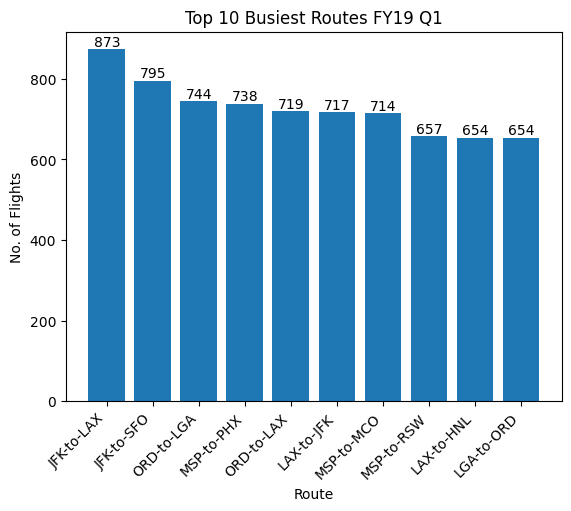

In [13]:
# 10 busiest routes
busy_routes = plt.bar(busiest_vis['ROUTE'], busiest_vis['ROUNDTRIP'])
plt.bar_label(busy_routes)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Busiest Routes FY19 Q1')
plt.xlabel('Route')
plt.ylabel('No. of Flights')
plt.savefig("top_10_busiest.png")
plt.show()


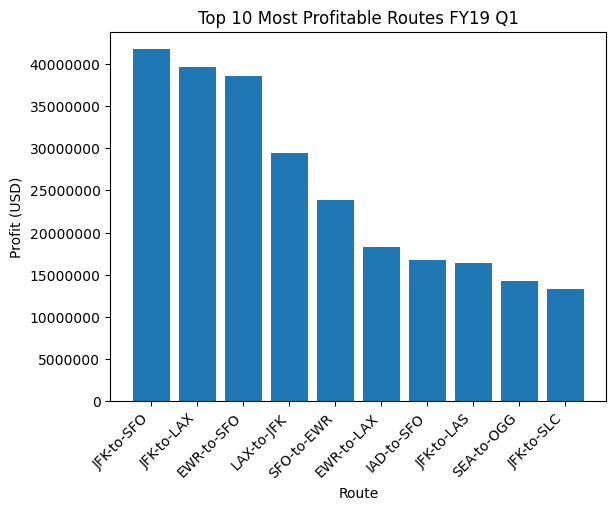

In [14]:
# 10 most profitable routes
plt.bar(results_df['ROUTE'], results_df['PROFIT'])
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format (style='plain', axis='y')
plt.title('Top 10 Most Profitable Routes FY19 Q1')
plt.xlabel('Route')
plt.ylabel('Profit (USD)')
plt.savefig("top_10_profit.png")
plt.show()

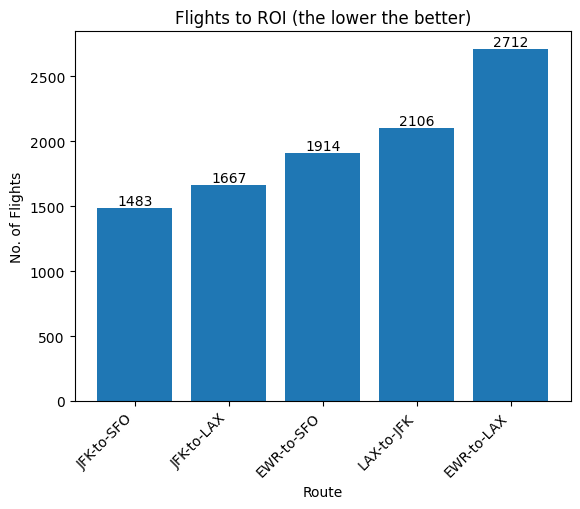

In [15]:
# flights to ROI
roi = plt.bar(investment_df['ROUTE'],investment_df['ROI'].sort_values())
plt.bar_label(roi)
plt.xticks(rotation=45, ha='right')
plt.title('Flights to ROI (the lower the better)')
plt.xlabel('Route')
plt.ylabel('No. of Flights')
plt.savefig("investment_roi.png")
plt.show()